## Dragon Riders

### Feature generation and Classical ML

Part of Grigoriy Kryukov

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [2]:
# upload data
df = pd.read_csv("train.csv")

In [3]:
df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [4]:
df['full_text'][0]

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

I have no doubt that advanced models, such as DeBERTaV3, will cope with the task much better than the methods of classical ML. However, our course is ML, not DL. Therefore, at least one person from the team should show the power of classical methods.

To apply classical methods, we need features. I deliberately refuse pre-irradiated embeddings and try to show imagination and knowledge of computational linguistics.

Let's list a list of features that could potentially be useful.

- $\textbf{The number of tokens}$. To count them, we use the nltk.tokenize.word_tokenize. There is a hypothesis that the better a person knows the language, the more voluminous an essay he can write.
- $\textbf{The number of words and ratio words/tokens}$. Clearing tokens from punctuation. Perhaps a more literate person will use more punctuation marks.
- $\textbf{The number and share of words not included in the list nltk.corpus.stopwords}$. (Frequently used words that do not carry a semantic load). There are two hypotheses here. On the one hand, the less a person uses stop words, the more diverse and meaningful speech. On the other hand, a person who does not know English well may forget about the stop words "a", "the" and the like.
- $\textbf{The average and median length of words}$. Perhaps the longer the words, the more complex they are and the better the person using them knows English.
- $\textbf{The number of sentences}$. There is a hypothesis that the better a person knows the language, the more sentences he can leave.
- $\textbf{The average and median length of sentences}$. There are two hypotheses here. On the one hand, a person who does not know English well is able to compose only short sentences. On the one hand, a person who does not know English well may compose sentences that are too long with a large number of words. Which is often not natural for English.
- $\textbf{The number of uses of a part of speech}$. The hypothesis is that in the letter of a person who does not know English well, there will be many prepositions (for example, 'of'). Conversely, an expert in English will use rare parts of speech, such as adverbs.

In [5]:
# example of stop words
stop_words = sorted(stopwords.words('english'))
stop_words[::20]

['a', 'before', "don't", 'here', 'm', 'on', 'shouldn', 'through', 'who']

In [6]:
# set of parts of speech

N = len(df)
punct = '!"#$%&()*\+,-\./:;<=>?@\[\]^_`{|}~„“«»†*\—/\-–‘’'

tags = []

for i in tqdm(range(N)):
    tokens = word_tokenize(df['full_text'][i])
    clean_words = [w.strip(punct) for w in tokens if w.strip(punct)]
    pos = pos_tag(clean_words, tagset = "universal")
    for j in range(len(clean_words)):
        tags.append(pos[j][1])

tags = list(set(tags))

100%|██████████| 3911/3911 [01:27<00:00, 44.45it/s]


In [7]:
N = len(df)

punct = '!"#$%&()*\+,-\./:;<=>?@\[\]^_`{|}~„“«»†*\—/\-–‘’'
stop_words = sorted(stopwords.words('english'))

for tag in tags:
    df[tag] = np.zeros(N)

for i in tqdm(range(N)):
    tokens = word_tokenize(df['full_text'][i])
    df.loc[i, "num_tokens"] = len(tokens)
    clean_words = [w.strip(punct) for w in tokens if w.strip(punct)]
    df.loc[i, "num_punct"] = len(clean_words)
    df.loc[i, "share_punct"] = 1 - len(clean_words) / len(tokens)
    good_words = [w for w in clean_words if w not in stop_words]
    df.loc[i, "num_nonstop"] = len(good_words)
    df.loc[i, "share_nonstop"] = len(good_words) / len(clean_words)
    arrlen = np.array([len(w) for w in good_words])
    df.loc[i, "avglen"] = arrlen.mean()
    df.loc[i, "medlen"] = np.median(arrlen)
    sents = sent_tokenize(df['full_text'][i])
    df.loc[i, "num_sents"] = len(sents)
    sentlen = np.array([len(word_tokenize(s)) for s in sents])
    df.loc[i, "avgsentlen"] = sentlen.mean()
    df.loc[i, "medsentlen"] = np.median(sentlen)
    pos = pos_tag(clean_words, tagset = "universal")
    for p in pos:
        if p[1] in tags:
            df.loc[i, p[1]] += 1.

100%|██████████| 3911/3911 [14:09<00:00,  4.61it/s]   


In [8]:
df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,DET,NOUN,...,num_tokens,num_punct,share_punct,num_nonstop,share_nonstop,avglen,medlen,num_sents,avgsentlen,medsentlen
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,17.0,47.0,...,283.0,264.0,0.067138,134.0,0.507576,5.111940,5.0,18.0,15.722222,14.5
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,39.0,89.0,...,554.0,536.0,0.032491,226.0,0.421642,5.376106,5.0,14.0,39.571429,25.0
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,29.0,70.0,...,356.0,330.0,0.073034,165.0,0.500000,4.769697,4.0,19.0,18.736842,19.0
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,51.0,93.0,...,836.0,759.0,0.092105,352.0,0.463768,5.073864,5.0,36.0,23.222222,22.5
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,27.0,59.0,...,237.0,234.0,0.012658,112.0,0.478632,5.437500,6.0,3.0,79.000000,42.0


The data is ready. Now we split the sample into train and test to evaluate the quality of the model.

In [9]:
train, test = train_test_split(df, train_size = 0.8, random_state=42)

In [10]:
train.columns[8:]

Index(['DET', 'NOUN', 'VERB', 'X', 'NUM', 'ADJ', 'ADP', 'PRON', 'ADV', 'PRT',
       'CONJ', '.', 'num_tokens', 'num_punct', 'share_punct', 'num_nonstop',
       'share_nonstop', 'avglen', 'medlen', 'num_sents', 'avgsentlen',
       'medsentlen'],
      dtype='object')

Now we implement a function that takes machine learning models as input, trains on a training sample and returns RMSE for a test sample.

Since we have six target metrics, the RMSE will be calculated for each of them.

In [60]:
X_train = train[list(train.columns)[8:]]
X_test = test[list(test.columns)[8:]]
y_col = list(train.columns[2:8])

def estimate_RMSE(main_model):
    
    models = []
    
    for col in y_col:
        model = main_model
        model.fit(X_train, train[col])
        models.append(model)

    preds = []

    for model in models:
        preds.append(model.predict(X_test))
        
    RMSE = np.zeros(len(preds))
    for i in range(len(preds)):
        RMSE[i] = MSE(test[y_col[i]], preds[i], squared=False)
        
    return RMSE

Let's try to apply different models.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

In [17]:
main_models = [LinearRegression(), Ridge(), Lasso(), SVR(), KNeighborsRegressor(),
         DecisionTreeRegressor(random_state=42), RandomForestRegressor(random_state=42),
         AdaBoostRegressor(random_state=42), XGBRegressor(random_state=42)]

scores = np.zeros((len(main_models), len(y_col)))
for i, model in enumerate(main_models):
    scores[i] = estimate_RMSE(model)
    
scores.round(4)

array([[0.5835, 0.5805, 0.5378, 0.6022, 0.6515, 0.5989],
       [0.5831, 0.5806, 0.5378, 0.6021, 0.6515, 0.5993],
       [0.6159, 0.6133, 0.5561, 0.6301, 0.6806, 0.6457],
       [0.5927, 0.5878, 0.5431, 0.6099, 0.6563, 0.6194],
       [0.6373, 0.6608, 0.5887, 0.6555, 0.7058, 0.6681],
       [0.866 , 0.8423, 0.84  , 0.8684, 0.8924, 0.8834],
       [0.5875, 0.5845, 0.537 , 0.6153, 0.6536, 0.6163],
       [0.5928, 0.5996, 0.5353, 0.6172, 0.6697, 0.6269],
       [0.6286, 0.6205, 0.5818, 0.6482, 0.6872, 0.6431]])

The best average result is shown by linear regression.

In [18]:
MCRMSE = scores.mean(axis=1)
print(MCRMSE.round(3))
print(main_models[np.argmin(MCRMSE)])

[0.592 0.592 0.624 0.602 0.653 0.865 0.599 0.607 0.635]
LinearRegression()


However, we can use different models to predict different metrics!

Let's find out which models did a better job of predicting different variables.

In [19]:
print("Best models:")
print()
for i in range(len(y_col)):
    ind_best = np.argmin(scores, axis=0)
    print(y_col[i], main_models[ind_best[i]])
    np.argmin(scores, axis=0)

Best models:

cohesion Ridge()
syntax LinearRegression()
vocabulary AdaBoostRegressor(random_state=42)
phraseology Ridge()
grammar LinearRegression()
conventions LinearRegression()


We use these models.

On the internal test, a score of $0.59$ was obtained.

The score on the kaggle public leaderboard was higher. $0.56$.

In [20]:
np.min(scores, axis=0).mean()

0.5918969195416927

![score1](./score1.png)

This is only $0.13$ behind the first place.

We can say that we were able to get a good intermediate result without using embeddings and neural networks!

### Tuning hyperparameters

Ridge

In [24]:
from sklearn.model_selection import GridSearchCV

for col in y_col:
    params = {'alpha': np.logspace(-4, 4, 100, base=10)}
    model = Ridge(random_state=42)
    GS = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=5)
    GS.fit(X_train, train[col])
    print(col, GS.best_estimator_)

cohesion Ridge(alpha=242.01282647943833, random_state=42)
syntax Ridge(alpha=114.9756995397738, random_state=42)
vocabulary Ridge(alpha=31.257158496882415, random_state=42)
phraseology Ridge(alpha=200.923300256505, random_state=42)
grammar Ridge(alpha=422.9242874389508, random_state=42)
conventions Ridge(alpha=138.48863713938746, random_state=42)


In [33]:
main_models = [Ridge(alpha=i, random_state=42) for i in [242, 115, 31, 201, 423, 138]]

scores = np.zeros((len(main_models), len(y_col)))
for i, model in enumerate(main_models):
    scores[i] = estimate_RMSE(model)
    
scores.round(4)

array([[0.583 , 0.5812, 0.5381, 0.6014, 0.6507, 0.6003],
       [0.5827, 0.5808, 0.5378, 0.6013, 0.6508, 0.5997],
       [0.5827, 0.5806, 0.5376, 0.6016, 0.6511, 0.5994],
       [0.5829, 0.581 , 0.538 , 0.6013, 0.6507, 0.6001],
       [0.5835, 0.5817, 0.5386, 0.6018, 0.6508, 0.6011],
       [0.5827, 0.5808, 0.5378, 0.6013, 0.6507, 0.5998]])

In [34]:
np.diag(scores)

array([0.58297072, 0.58077563, 0.53763922, 0.60131356, 0.65081244,
       0.59975822])

In [36]:
np.diag(scores).mean()

0.5922116317894863

Random Forest Regression

In [32]:
for col in y_col:
    params = {'n_estimators': np.arange(100, 550, 100), 'max_depth': np.arange(5, 20, 5)}
    model = RandomForestRegressor(random_state=42)
    GS = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=5)
    GS.fit(X_train, train[col])
    print(col, GS.best_estimator_)

cohesion RandomForestRegressor(max_depth=10, n_estimators=500, random_state=42)
syntax RandomForestRegressor(max_depth=10, n_estimators=400, random_state=42)
vocabulary RandomForestRegressor(max_depth=10, n_estimators=500, random_state=42)
phraseology RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)
grammar RandomForestRegressor(max_depth=10, n_estimators=400, random_state=42)
conventions RandomForestRegressor(max_depth=10, n_estimators=500, random_state=42)


In [37]:
main_models = [RandomForestRegressor(max_depth=10, n_estimators=500, random_state=42), 
              RandomForestRegressor(max_depth=10, n_estimators=400, random_state=42),
              RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)]

scores = np.zeros((len(main_models), len(y_col)))
for i, model in enumerate(main_models):
    scores[i] = estimate_RMSE(model)
    
scores.round(4)

array([[0.5823, 0.5785, 0.5326, 0.611 , 0.6541, 0.611 ],
       [0.5823, 0.579 , 0.5322, 0.611 , 0.6543, 0.6114],
       [0.5848, 0.5803, 0.5358, 0.6121, 0.653 , 0.6112]])

In [29]:
for i in range(len(y_col)):
    ind_best = np.argmin(scores, axis=0)
    print(y_col[i], main_models[ind_best[i]])
    np.argmin(scores, axis=0)

cohesion RandomForestRegressor(max_depth=10, n_estimators=175, random_state=42)
syntax RandomForestRegressor(max_depth=10, n_estimators=175, random_state=42)
vocabulary RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42)
phraseology RandomForestRegressor(max_depth=10, n_estimators=150, random_state=42)
grammar RandomForestRegressor(max_depth=15, random_state=42)
conventions RandomForestRegressor(max_depth=10, n_estimators=175, random_state=42)


In [39]:
(scores[0][0] + scores[1][1] + scores[0][2] + scores[2][3] + scores[1][4] + scores[0][5]) / 6

0.5952202755105946

Conclusion: the change in hyperparameters did not give significant improvements compared to the main model.

### Statistical analysis

Let's build linear regressions and study the statistical results.

We see that the value of $R^2$ is small, so it is difficult to draw conclusions. However, we can construct a confidence interval for the values of the coefficients. A more detailed analysis of the results is shown on the slides.

In [40]:
import statsmodels.api as sm

In [41]:
for col in y_col:
    mod = sm.OLS(df[col], sm.add_constant(df.iloc[:,8:]))
    res = mod.fit()
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               cohesion   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     49.74
Date:                Fri, 23 Dec 2022   Prob (F-statistic):          7.82e-183
Time:                        14:35:01   Log-Likelihood:                -3473.7
No. Observations:                3911   AIC:                             6991.
Df Residuals:                    3889   BIC:                             7129.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.4630      0.274      5.347

In [42]:
# check correlation

np.corrcoef(df.iloc[:,2:].T)[6:,:6].round(2)

array([[ 0.16,  0.12,  0.2 ,  0.13,  0.03,  0.09],
       [ 0.22,  0.18,  0.26,  0.18,  0.06,  0.13],
       [ 0.21,  0.2 ,  0.27,  0.23,  0.1 ,  0.15],
       [-0.05, -0.04, -0.04, -0.05, -0.04, -0.06],
       [ 0.06,  0.03,  0.04,  0.04,  0.  ,  0.02],
       [ 0.2 ,  0.16,  0.24,  0.18,  0.06,  0.11],
       [ 0.24,  0.2 ,  0.27,  0.23,  0.1 ,  0.17],
       [ 0.12,  0.12,  0.18,  0.15,  0.04,  0.08],
       [ 0.19,  0.18,  0.24,  0.23,  0.11,  0.15],
       [ 0.19,  0.17,  0.23,  0.19,  0.08,  0.13],
       [ 0.1 ,  0.08,  0.18,  0.13,  0.02,  0.05],
       [ 0.03,  0.04,  0.07,  0.05,  0.02,  0.02],
       [ 0.23,  0.2 ,  0.28,  0.22,  0.09,  0.16],
       [ 0.22,  0.19,  0.27,  0.22,  0.08,  0.14],
       [ 0.23,  0.21,  0.17,  0.13,  0.13,  0.22],
       [ 0.26,  0.24,  0.31,  0.25,  0.13,  0.19],
       [ 0.18,  0.19,  0.16,  0.14,  0.18,  0.18],
       [ 0.18,  0.15,  0.19,  0.12,  0.08,  0.15],
       [ 0.17,  0.16,  0.19,  0.14,  0.1 ,  0.15],
       [ 0.33,  0.35,  0.34,  0

Let's visualize the most interesting results (variables with the highest absolute correlation value).

In [43]:
# idea from https://www.kaggle.com/code/akershishukla/language-feedback-eda-feature-engineering

def draw_boxplot(var):
    plt.figure(figsize=(15,20))
    n=1
    for col in y_col:
        plt.subplot(3,2,n)
        plt.grid()
        sns.boxplot(data=df,x=col,y=var)
        n +=1

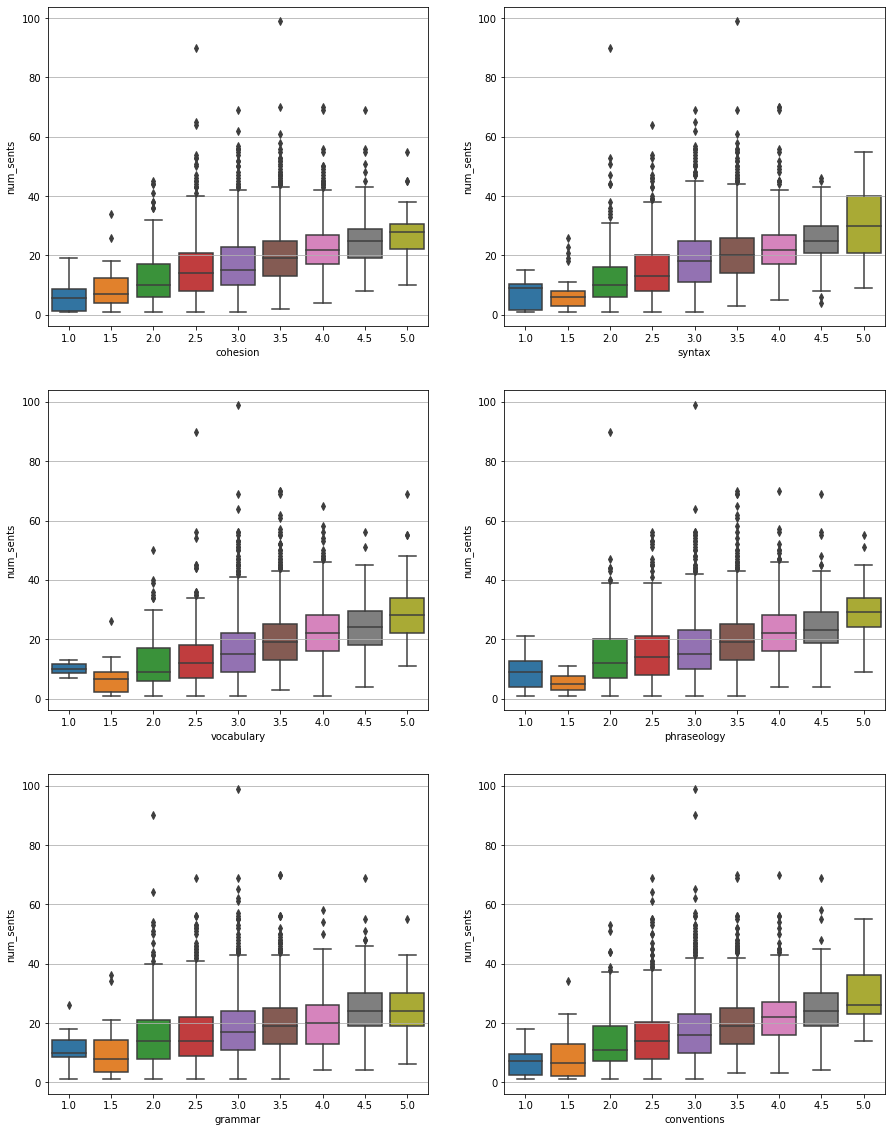

In [44]:
draw_boxplot("num_sents")

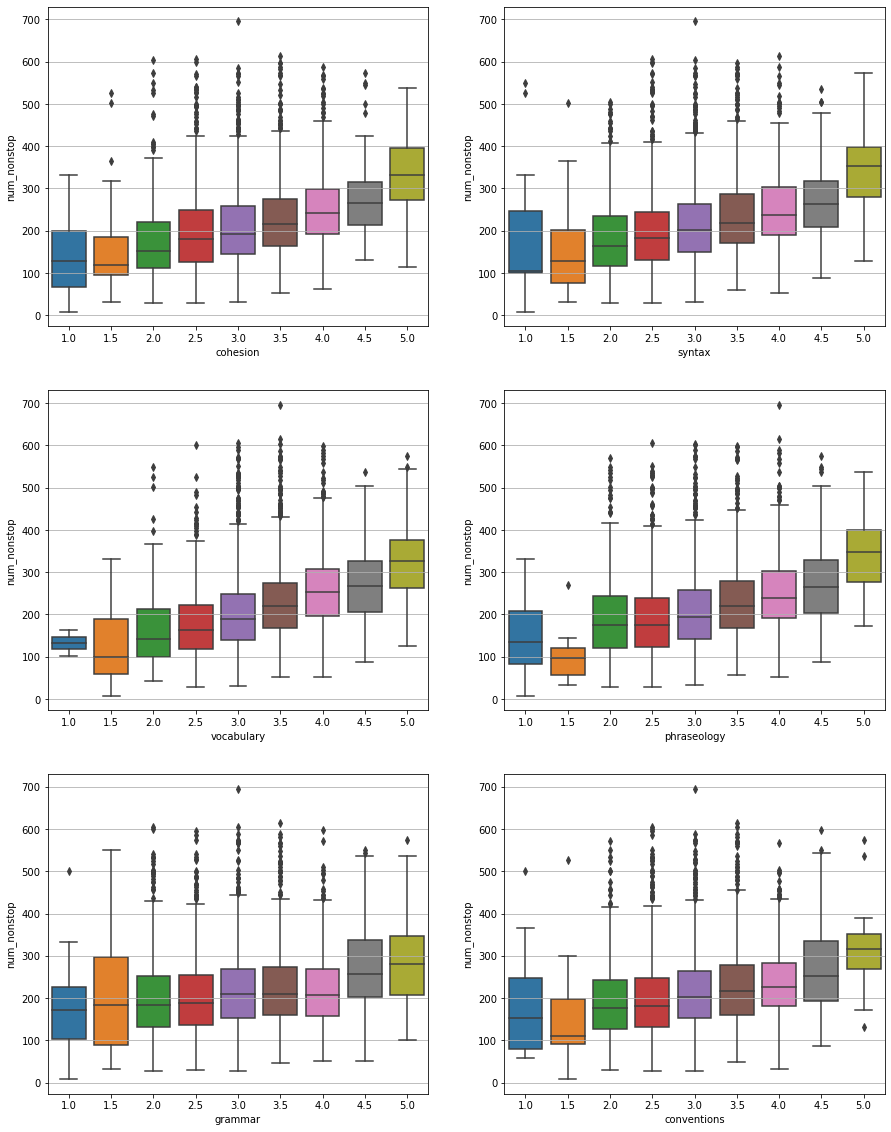

In [45]:
draw_boxplot("num_nonstop")

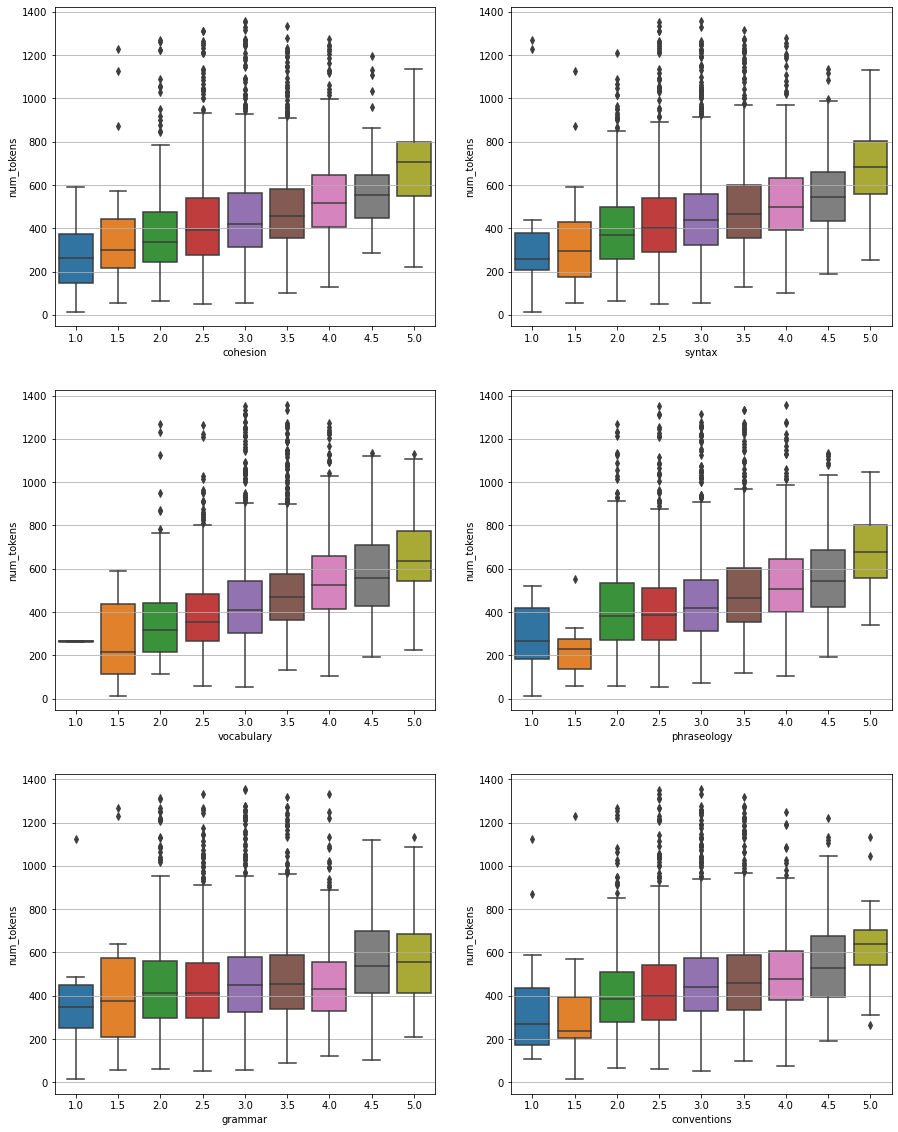

In [46]:
draw_boxplot("num_tokens")

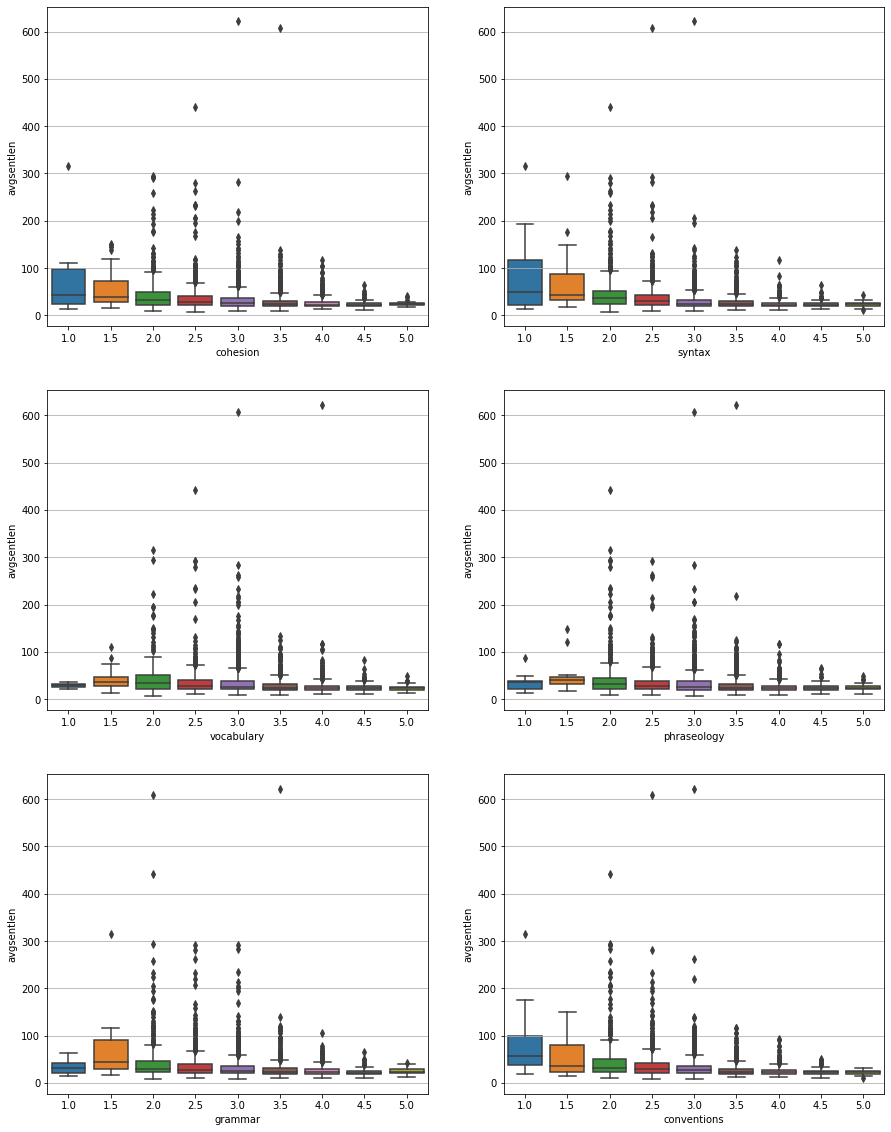

In [47]:
draw_boxplot("avgsentlen")

More detailed conclusions are available in the presentation.

### Shapley Value 

As we can see, there are three variables that can be easily calculated by the teacher and at the same time correlate with the final grade:

- number of words
- number of sentences
- average length of sentence

Which of the variables is the most informative?
Let's use the Shapley value to answer this question.

https://en.wikipedia.org/wiki/Shapley_value

In [59]:
def estimate_RMSE_for_Shapley(main_model, features):
    
    models = []
    
    for col in y_col:
        model = main_model
        model.fit(X_train[features], train[col])
        models.append(model)

    preds = []

    for model in models:
        preds.append(model.predict(X_test[features]))
        
    RMSE = np.zeros(len(preds))
    for i in range(len(preds)):
        RMSE[i] = MSE(test[y_col[i]], preds[i], squared=False)
        
    return RMSE

In [80]:
estimate_RMSE_for_Shapley(LinearRegression(), ['num_tokens', 'num_sents', 'avgsentlen'])

array([0.6159731 , 0.60494554, 0.55384695, 0.63013759, 0.67746736,
       0.63966647])

In [85]:
from itertools import permutations

ShScore = np.zeros((6,3))
ShCol = ['num_tokens', 'num_sents', 'avgsentlen']

from itertools import permutations

for k, perm in enumerate(permutations([0,1,2])):
    base_score = 0 # any number
    features = []
    for i in perm:
        features.append(ShCol[i])
        new_score = - estimate_RMSE_for_Shapley(LinearRegression(), features).mean()
        ShScore[k][i] = new_score - base_score
        base_score = new_score

In [86]:
ShScore.round(3)

array([[-0.644,  0.02 ,  0.004],
       [-0.644,  0.006,  0.017],
       [ 0.   , -0.624,  0.004],
       [ 0.   , -0.624,  0.004],
       [ 0.012,  0.006, -0.639],
       [ 0.   ,  0.018, -0.639]])

In [87]:
ShScore.mean(axis=0)

array([-0.21246377, -0.19978592, -0.20808982])

Thus, by significance, the variables are arranged in the following order (from the most significant to the least):

- number of sentences
- average length of sentence
- number of words